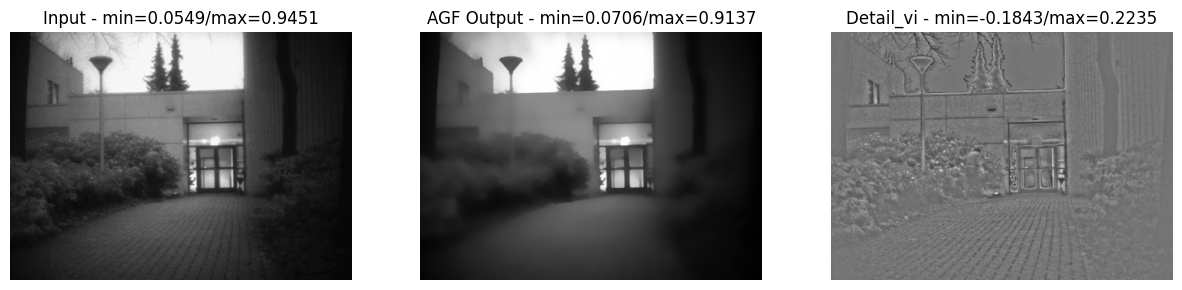

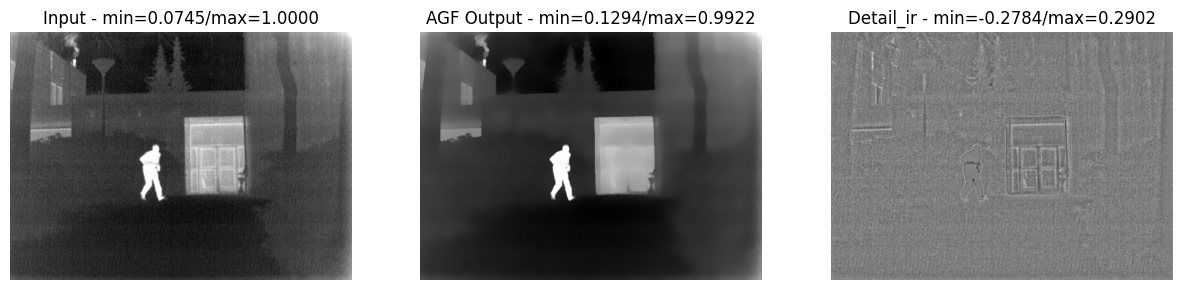

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from decomposition.AGF_decomposition import agf_decomposition

# Decompose the visible image
img_vi = cv2.imread(".\\data\\TNO\\vi\\17.png", cv2.IMREAD_GRAYSCALE)
img_vi = img_vi.astype(np.float32) / 255.0

base_vi, detail_vi = agf_decomposition(
    img_vi,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_vi.min():.4f}/max={img_vi.max():.4f}"); plt.imshow(img_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_vi.min():.4f}/max={base_vi.max():.4f}"); plt.imshow(base_vi, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_vi - min={detail_vi.min():.4f}/max={detail_vi.max():.4f}"); plt.imshow(detail_vi, cmap="gray"); plt.axis("off")
plt.show()

# Decompose the infrared image
img_ir = cv2.imread(".\\data\\TNO\\ir\\17.png", cv2.IMREAD_GRAYSCALE)
img_ir = img_ir.astype(np.float32) / 255.0  

base_ir, detail_ir = agf_decomposition(
    img_ir,
    sigma_spatial=5,
    sigma_range=0.05,
    iterations=4,
    median_ksize=3,
    numba=True
)

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.title(f"Input - min={img_ir.min():.4f}/max={img_ir.max():.4f}"); plt.imshow(img_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"AGF Output - min={base_ir.min():.4f}/max={base_ir.max():.4f}"); plt.imshow(base_ir, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Detail_ir - min={detail_ir.min():.4f}/max={detail_ir.max():.4f}"); plt.imshow(detail_ir, cmap="gray"); plt.axis("off")
plt.show()

In [4]:
restruct_vi = base_vi + detail_vi
restruct_ir = base_ir + detail_ir

# Tính PSNR giữa ảnh gốc và ảnh tái cấu trúc
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

psnr_vi = psnr(img_vi, restruct_vi)
psnr_ir = psnr(img_ir, restruct_ir)
print(f"PSNR between original and reconstructed visible image: {psnr_vi:.2f} dB")
print(f"PSNR between original and reconstructed infrared image: {psnr_ir:.2f} dB")

PSNR between original and reconstructed visible image: inf dB
PSNR between original and reconstructed infrared image: inf dB


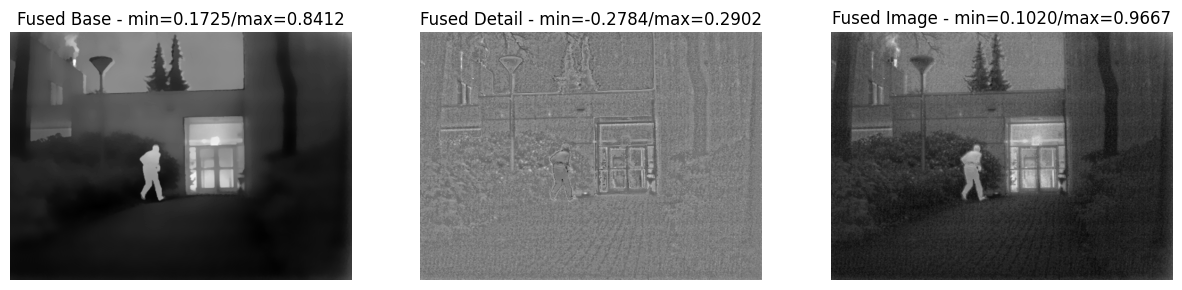

In [ ]:
from detail_fusion.MGA_WLE import fuse_detail_dynamic_WLE_im2col

base_fused = np.maximum(base_vi, base_ir)
detail_fulsed = fuse_detail_dynamic_WLE_im2col(detail_ir, detail_vi)
fused = np.clip(base_fused + detail_fulsed, 0, 1)

cv2.imwrite(".\\data\\output\\AGF_fusion_base.png", (fused * 255).astype(np.uint8))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title(f"Fused Base - min={base_fused.min():.4f}/max={base_fused.max():.4f}"); plt.imshow(base_fused, cmap="gray"); plt.axis("off")
plt.subplot(1,3,2); plt.title(f"Fused Detail - min={detail_fulsed.min():.4f}/max={detail_fulsed.max():.4f}"); plt.imshow(detail_fulsed, cmap="gray"); plt.axis("off")
plt.subplot(1,3,3); plt.title(f"Fused Image - min={fused.min():.4f}/max={fused.max():.4f}"); plt.imshow(fused, cmap="gray"); plt.axis("off")
plt.show()

In [18]:
import pandas as pd
from metric.eval_one_image import evaluation_one

ir_image = ".\\data\\TNO\\ir\\17.png"
vi_image = ".\\data\\TNO\\vi\\17.png"
fused_image = ".\\data\\output\\AGF_fusion_base.png"

EN, MI, SF, AG, SD, MLI, CC, SCD, VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM = evaluation_one(ir_image, vi_image, fused_image)

# Tạo bảng kết quả
data = {
    "Metric": [
        "EN", "MI", "SF", "AG", "SD", "MLI", "CC", "SCD",
        "VIF", "MSE", "PSNR", "Qabf", "Nabf", "SSIM", "MS_SSIM"
    ],
    "Value": [
        EN, MI, SF, AG, SD, MLI, CC, SCD,
        VIF, MSE, PSNR, Qabf, Nabf, SSIM, MS_SSIM
    ]
}

df = pd.DataFrame(data)

# Làm tròn cho đẹp (tuỳ chọn)
df["Value"] = df["Value"].round(6)

# Hiển thị bảng
print(df)


torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
torch.Size([1, 1, 1, 450, 620]) torch.Size([1, 1, 1, 450, 620])
     Metric      Value
0        EN   6.666684
1        MI   1.865245
2        SF   8.040190
3        AG   3.470403
4        SD  32.058919
5       MLI  82.061226
6        CC   0.605798
7       SCD   1.547919
8       VIF   0.563284
9       MSE   0.023282
10     PSNR  64.460544
11     Qabf   0.483990
12     Nabf   0.023271
13     SSIM   0.478414
14  MS_SSIM   0.475903


In [ ]:
'''
| Method     | EN       | MI       | SF       | AG       | SD        | MLI        | CC       | SCD      | VIF      | MSE      | PSNR      | Qabf     | Nabf     | SSIM     | MS_SSIM  |
| ---------- | -------- | -------- | -------- | -------- | --------- | ---------- | -------- | -------- | -------- | -------- | --------- | -------- | -------- | -------- | -------- |
| **Hybrid** | 7.208120 | 4.879086 | 9.190707 | 3.767345 | 51.170933 | 110.988258 | 0.551578 | 1.679293 | 0.701313 | 0.045881 | 61.514443 | 0.563514 | 0.023612 | 0.476956 | 0.481888 |
| **Gauss**  | 7.209418 | 4.797899 | 9.255032 | 3.767096 | 51.167653 | 111.005035 | 0.551622 | 1.679559 | 0.676422 | 0.045888 | 61.513808 | 0.546354 | 0.026886 | 0.476879 | 0.484646 |
| **Var**    | 7.208080 | 4.881440 | 9.183662 | 3.766703 | 51.171204 | 110.987473 | 0.551577 | 1.679295 | 0.703012 | 0.045881 | 61.514496 | 0.564343 | 0.023266 | 0.476993 | 0.481696 |

'''